## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Configs

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

## UDFs

In [3]:
def count_plot(x, dataframe, ax=None, **kwargs):
    if len(kwargs)==1 and kwargs['mode']=='horizontal':
        sns.countplot(y=x, data=dataframe, ax=ax, order=dataframe[x].value_counts().index)
    else:
        sns.countplot(x=x, data=dataframe, ax=ax, order=dataframe[x].value_counts().index)
    plt.box(False)
    return None

    
def pie_plot(df_col, fig_size, title):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.pie(df_col.values, autopct='%1.2f%%', shadow=False, startangle=90)
    ax.axis('equal')
    plt.legend(labels=df_col.index, bbox_to_anchor=(1.05, 1))
    plt.title(title)
    plt.show()
    return None


def stacked_vBar_plot(dataframe, value, index, column, xlabel, fig_size, scale='linear', with_percent=True):
    
    df_1 = dataframe.pivot_table(values=[value], index=[index], columns=[column], aggfunc=len, margins=True)
    df_1_percent = df_1.div(df_1.iloc[:,-1], axis=0).mul(100, axis=0).round(2)
    df_2_percent = df_1_percent.iloc[:, :-1].drop('All')
    
    columns = df_2_percent.columns.levels[1].tolist()
    columns.remove('All')
    
    ax = df_2_percent.plot.bar(stacked=True)
    ax.figure.set_size_inches(fig_size)
    ax.grid(False)
    plt.legend(labels=columns, bbox_to_anchor=(1.05, 1), title='NPS Type')
    plt.xlabel(xlabel)
    plt.ylabel('%GT Count of NPS_Type')
    
    if with_percent:
        # Add this loop to add the annotations
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.2f}%'.format(height), (x + width/8, y + height/2))
    plt.box(False)
    plt.show()
    return None


def pdf_distribution_plots(df, features, target):
    nrow = int((len(features)/3) + len(features)%3)
    
    t0 = df.loc[df[target] == 0]
    t1 = df.loc[df[target] == 1]

    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(15,10))

    for indx, feature in enumerate(features):
        ax = fig.add_subplot(nrow, 3, indx+1)
        sns.kdeplot(t0[feature], label="0", legend=True)
        sns.kdeplot(t1[feature], label="1", legend=True)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_xlabel(feature, fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.legend(loc='best')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace= 0.3, hspace=0.5)
    plt.show()
    return None


def clipping(dataframe, num_cols):
    df_copy = dataframe.copy()
    for col in num_cols:
        p25 = np.percentile(df_copy[col], 25)
        p75 = np.percentile(df_copy[col], 75)
        iqr = p75 - p25
        df_copy[col] = np.clip(df_copy[col], a_min=np.floor((p25 - 1.5*iqr)), a_max=np.ceil((p75 + 1.5*iqr)))
    return df_copy


def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = col + '_CAT'
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

## Load Data

In [4]:
dir_path = '/kaggle/input/store-sales-time-series-forecasting/'

oil_df = pd.read_csv(dir_path + 'oil.csv')
holidays_df = pd.read_csv(dir_path + 'holidays_events.csv')
stores_df = pd.read_csv(dir_path + 'stores.csv')
train_df = pd.read_csv(dir_path + 'train.csv')
test_df = pd.read_csv(dir_path + 'test.csv')
trnsctns_df = pd.read_csv(dir_path + 'transactions.csv')

In [5]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [9]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [10]:
trnsctns_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## Basic Statistics

### Oil

In [11]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [12]:
print(f'Minimum oil price date: {oil_df["date"].min()}')
print(f'Maximum oil price date: {oil_df["date"].max()}')

Minimum oil price date: 2013-01-01
Maximum oil price date: 2017-08-31


### Holidays

In [13]:
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [14]:
print(f'Minimum date in holidays dataset: {holidays_df["date"].min()}')
print(f'Maximum date in holidays dataset: {holidays_df["date"].max()}')

Minimum date in holidays dataset: 2012-03-02
Maximum date in holidays dataset: 2017-12-26


In [15]:
holidays_df.describe(include=['object'])

,date,type,locale,locale_name,description
count,350,350,350,350,350
unique,312,6,3,24,103
top,2014-06-25,Holiday,National,Ecuador,Carnaval
freq,4,221,174,174,10


### Stores

In [16]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [17]:
stores_df.describe(include=['object'])

,city,state,type
count,54,54,54
unique,22,16,5
top,Quito,Pichincha,D
freq,18,19,18


### Train

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [25]:
print(f'Minimum date in training dataset: {train_df["date"].min()}')
print(f'Maximum date in training dataset: {train_df["date"].max()}')

Minimum date in training dataset: 2013-01-01
Maximum date in training dataset: 2017-08-15


In [20]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [23]:
train_df.drop(columns=['id','store_nbr']).describe(exclude=['object']).applymap('{:,.2f}'.format)

,sales,onpromotion
count,"3,000,888.00","3,000,888.00"
mean,357.78,2.60
std,"1,102.00",12.22
min,0.00,0.00
25%,0.00,0.00
50%,11.00,0.00
75%,195.85,0.00
max,"124,717.00",741.00


In [24]:
train_df.describe(include=['object'])

,date,family
count,3000888,3000888
unique,1684,33
top,2013-01-01,AUTOMOTIVE
freq,1782,90936


### Test

In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [27]:
print(f'Minimum date in test dataset: {test_df["date"].min()}')
print(f'Maximum date in test dataset: {test_df["date"].max()}')

Minimum date in test dataset: 2017-08-16
Maximum date in test dataset: 2017-08-31


In [28]:
test_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [29]:
test_df.drop(columns=['id','store_nbr']).describe(exclude=['object']).applymap('{:,.2f}'.format)

,onpromotion
count,"28,512.00"
mean,6.97
std,20.68
min,0.00
25%,0.00
50%,0.00
75%,6.00
max,646.00


In [32]:
test_df.describe(include=['object'])

,date,family
count,28512,28512
unique,16,33
top,2017-08-16,AUTOMOTIVE
freq,1782,864


### Transactions

In [33]:
trnsctns_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [35]:
print(f'Minimum date in transaction dataset: {trnsctns_df["date"].min()}')
print(f'Maximum date in transaction dataset: {trnsctns_df["date"].max()}')

Minimum date in transaction dataset: 2013-01-01
Maximum date in transaction dataset: 2017-08-15


In [34]:
trnsctns_df.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [37]:
trnsctns_df[['transactions']].describe().applymap('{:,.2f}'.format)

,transactions
count,"83,488.00"
mean,"1,694.60"
std,963.29
min,5.00
25%,"1,046.00"
50%,"1,393.00"
75%,"2,079.00"
max,"8,359.00"


## Data Pre-processing

In [38]:
holidays_df['date'] = pd.to_datetime(holidays_df['date'], format = "%Y-%m-%d")
oil_df['date'] = pd.to_datetime(oil_df['date'], format = "%Y-%m-%d")
trnsctns_df['date'] = pd.to_datetime(trnsctns_df['date'], format = "%Y-%m-%d")
train_df['date'] = pd.to_datetime(train_df['date'], format = "%Y-%m-%d")
test_df['date'] = pd.to_datetime(test_df['date'], format = "%Y-%m-%d")

## Univariate Analysis

### Oil

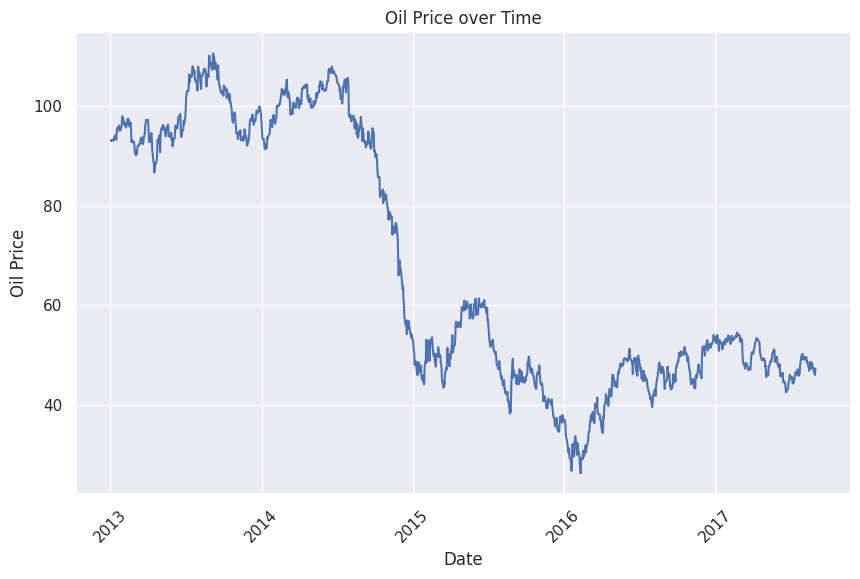

In [39]:
oil_df['date'] = pd.to_datetime(oil_df['date'])

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

# Line plot
sns.lineplot(x='date', y='dcoilwtico', data=oil_df, color='b')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.title('Oil Price over Time')
plt.xticks(rotation=45)
plt.show()

### Holidays

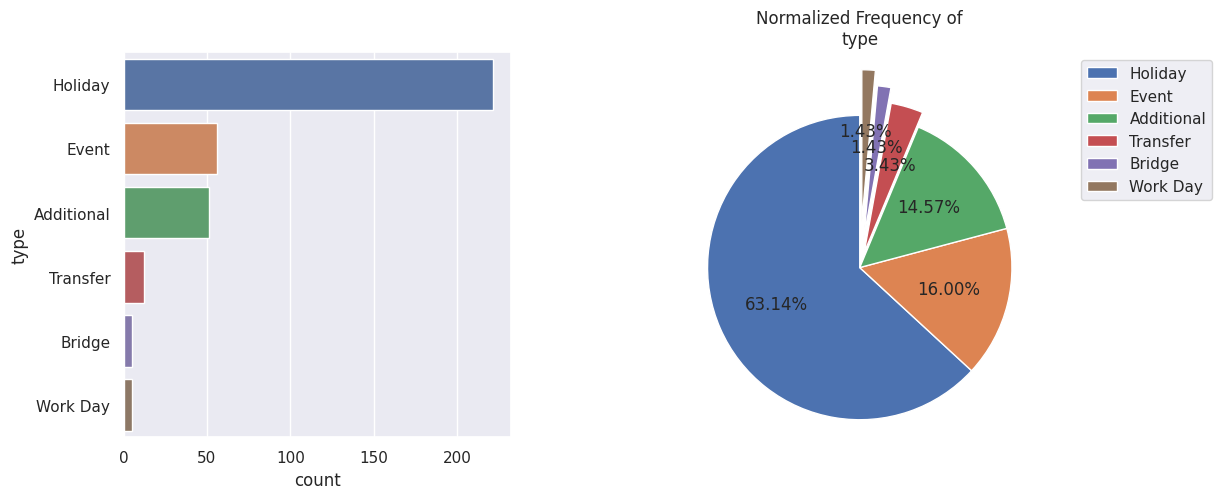

In [47]:
feature = 'type'
unique_id = 'date'

fig1, axes1 = plt.subplots(1, 2, figsize=(12,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=holidays_df, ax=axes1[0], mode='horizontal')

grouped_df = holidays_df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0,0,0,0.1,0.2,0.3))
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

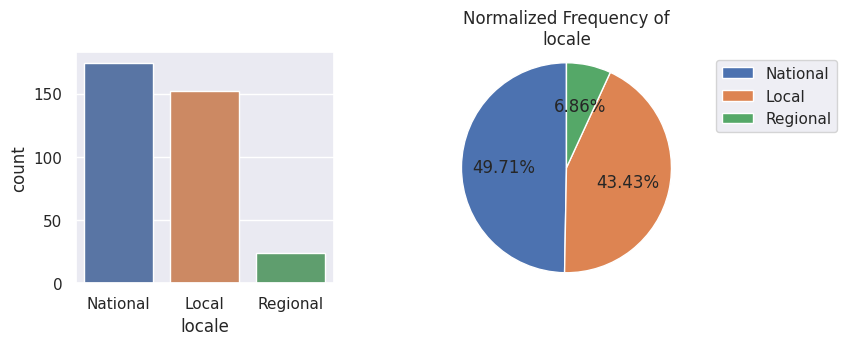

In [50]:
feature = 'locale'
unique_id = 'date'

fig1, axes1 = plt.subplots(1, 2, figsize=(8,3))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=holidays_df, ax=axes1[0])

grouped_df = holidays_df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

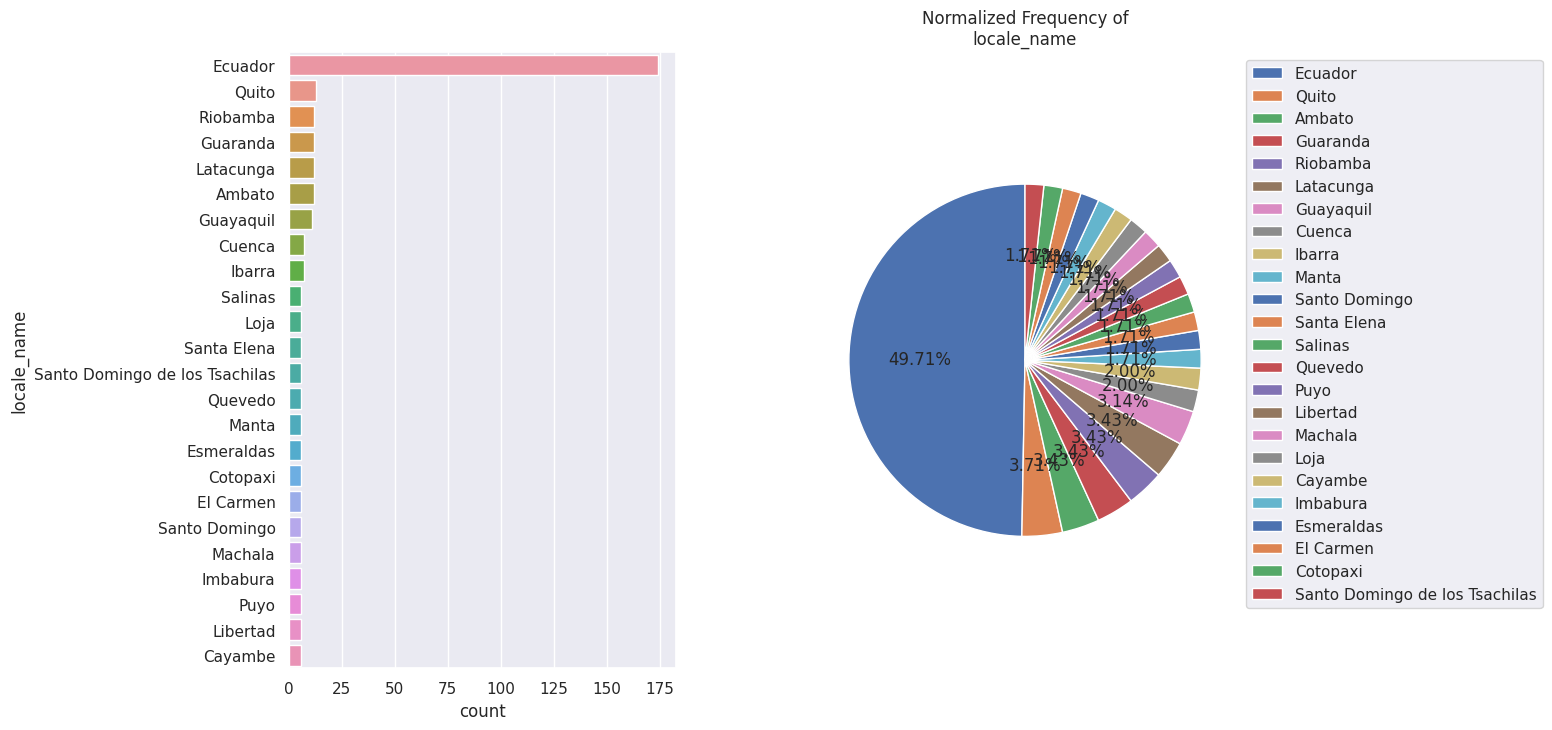

In [53]:
feature = 'locale_name'
unique_id = 'date'

fig1, axes1 = plt.subplots(1, 2, figsize=(12,8))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=holidays_df, ax=axes1[0], mode='horizontal')

grouped_df = holidays_df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

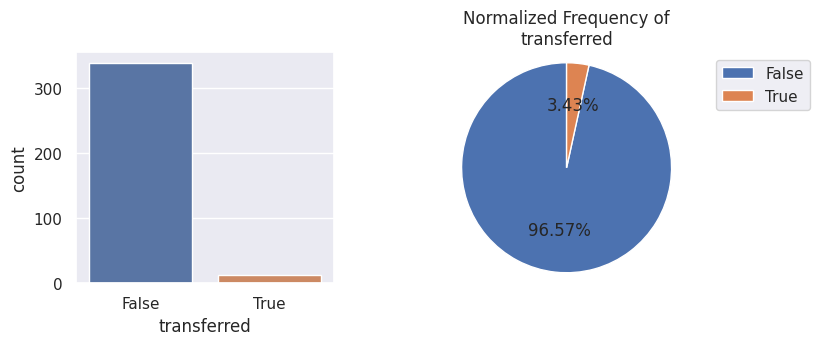

In [55]:
feature = 'transferred'
unique_id = 'date'

fig1, axes1 = plt.subplots(1, 2, figsize=(8,3))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=holidays_df, ax=axes1[0])

grouped_df = holidays_df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

### Transactions

Text(0.5, 1.0, 'Average Transactions in Each Week')

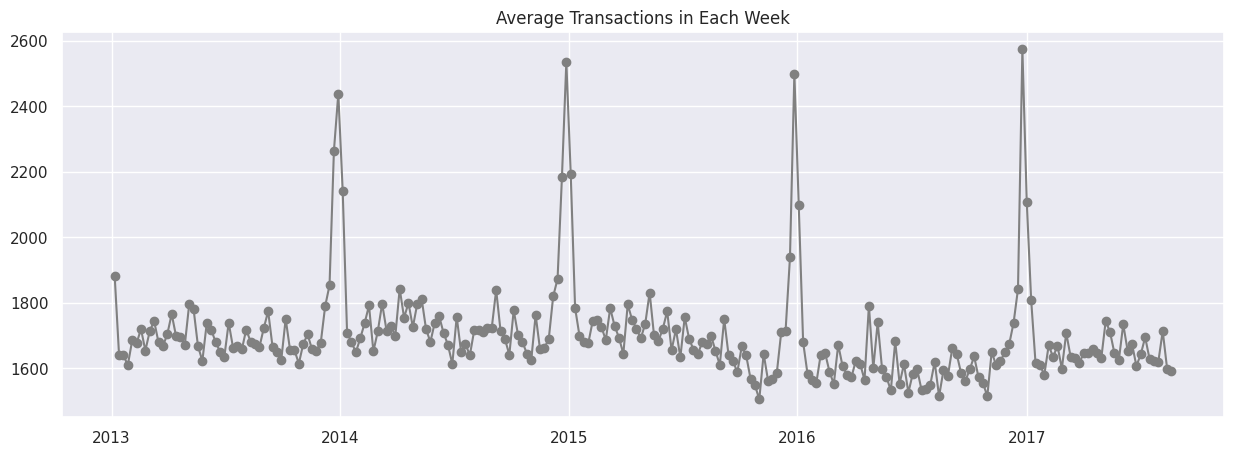

In [64]:
# Weekly transactions
trnsctns_w_grpd_df = trnsctns_df.groupby([pd.Grouper(key='date', freq='W')]).agg(mean = ('transactions', 'mean'))
trnsctns_w_grpd_df = trnsctns_w_grpd_df.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

axes.plot('date', 'mean', data=trnsctns_w_grpd_df, color='grey', marker='o')
axes.set_title("Average Transactions in Each Week", fontsize=12)

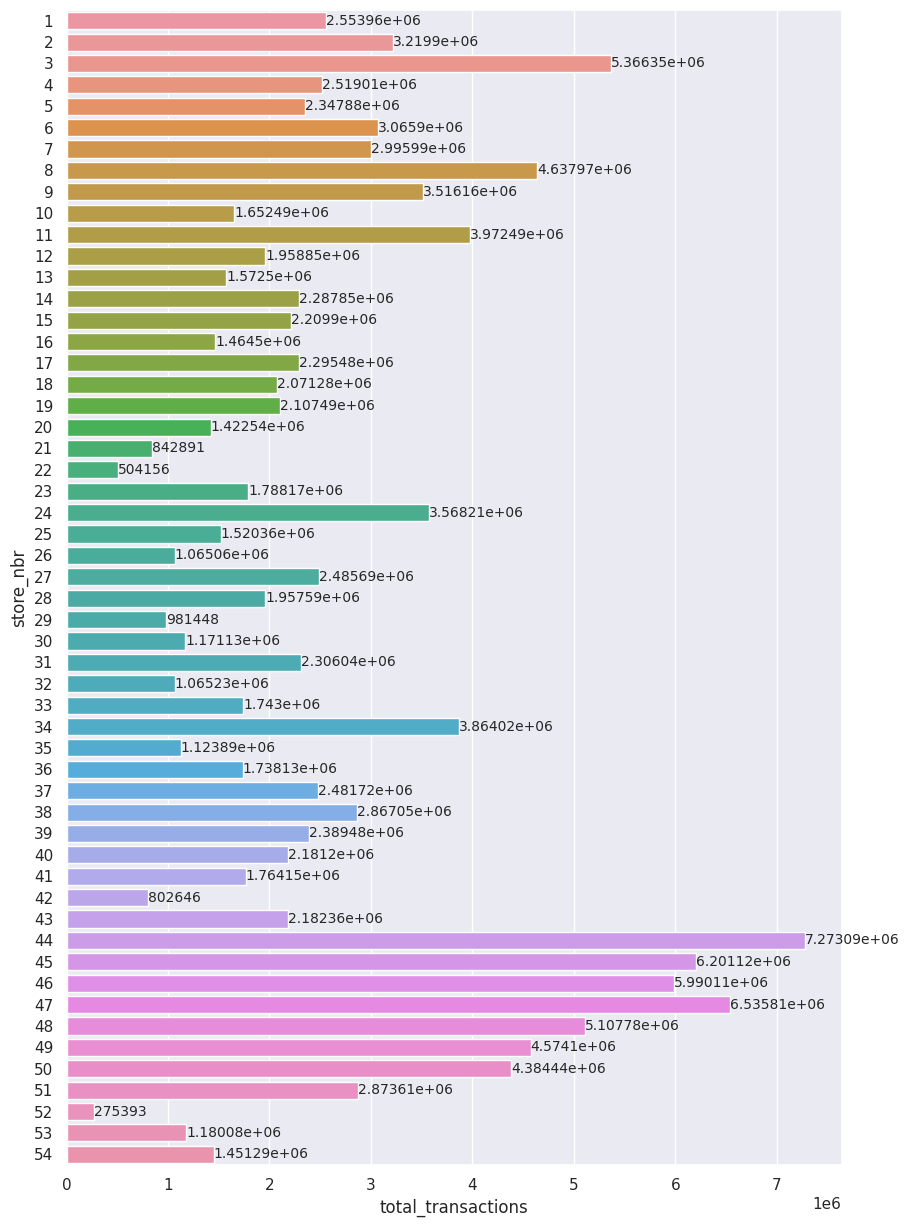

In [90]:
# Total transactions in each store

stre_trnsctns_grpd_df = trnsctns_df.groupby(['store_nbr']).agg(total_transactions = ('transactions', 'sum'))
stre_trnsctns_grpd_df = stre_trnsctns_grpd_df.reset_index()

feature = 'total_transactions'
unique_id = 'store_nbr'
df = stre_trnsctns_grpd_df

fig1, axes1 = plt.subplots(1, 1, figsize=(10,15))
axes1 = sns.barplot(data=stre_trnsctns_grpd_df, x='total_transactions', y='store_nbr', orient="h")
axes1.bar_label(axes1.containers[0], fontsize=10);

plt.show()

### Stores

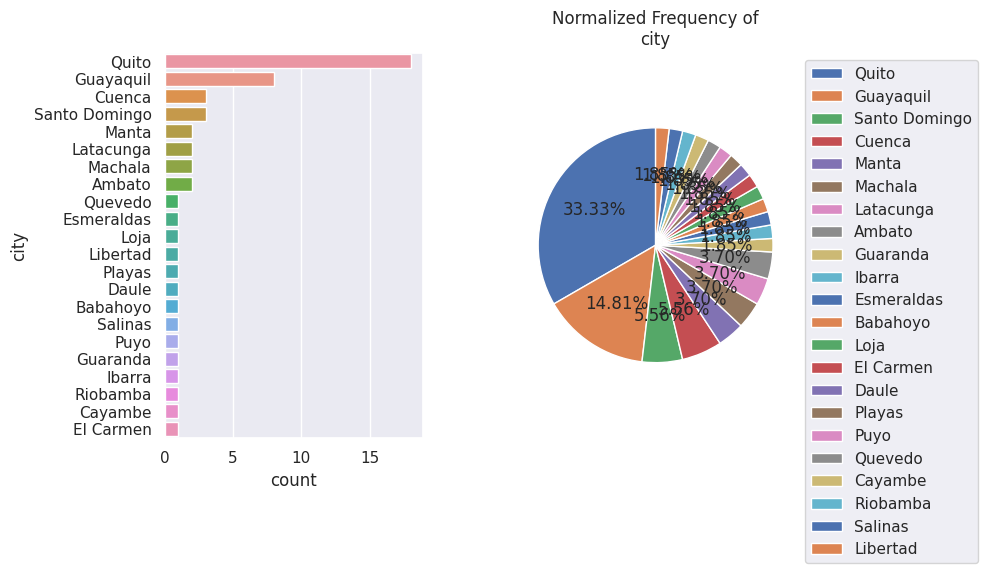

In [96]:
feature = 'city'
unique_id = 'store_nbr'
df = stores_df

fig1, axes1 = plt.subplots(1, 2, figsize=(8,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=df, ax=axes1[0], mode='horizontal')

grouped_df = df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

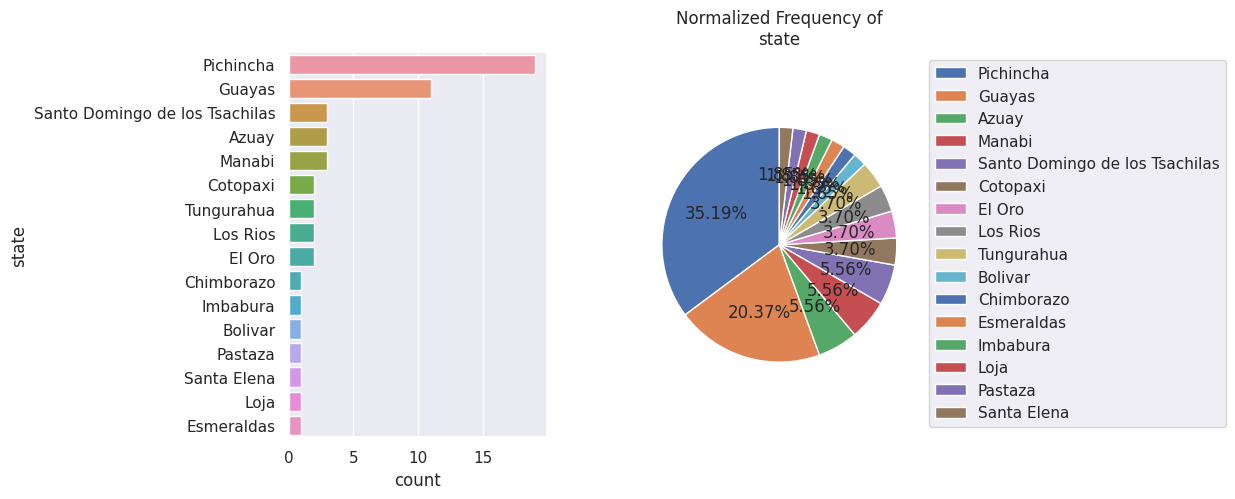

In [97]:
feature = 'state'
unique_id = 'store_nbr'
df = stores_df

fig1, axes1 = plt.subplots(1, 2, figsize=(8,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=df, ax=axes1[0], mode='horizontal')

grouped_df = df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

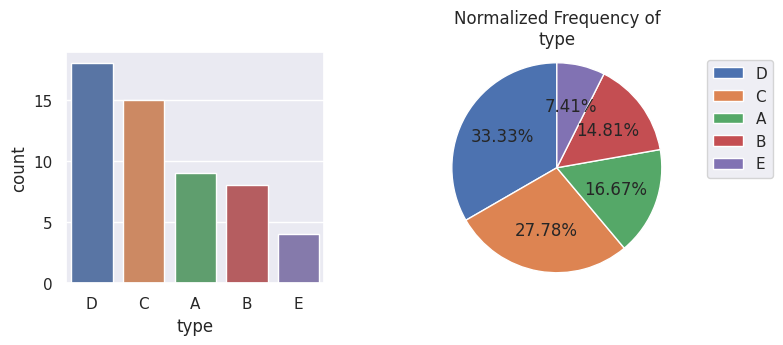

In [100]:
feature = 'type'
unique_id = 'store_nbr'
df = stores_df

fig1, axes1 = plt.subplots(1, 2, figsize=(8,3))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=df, ax=axes1[0])

grouped_df = df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

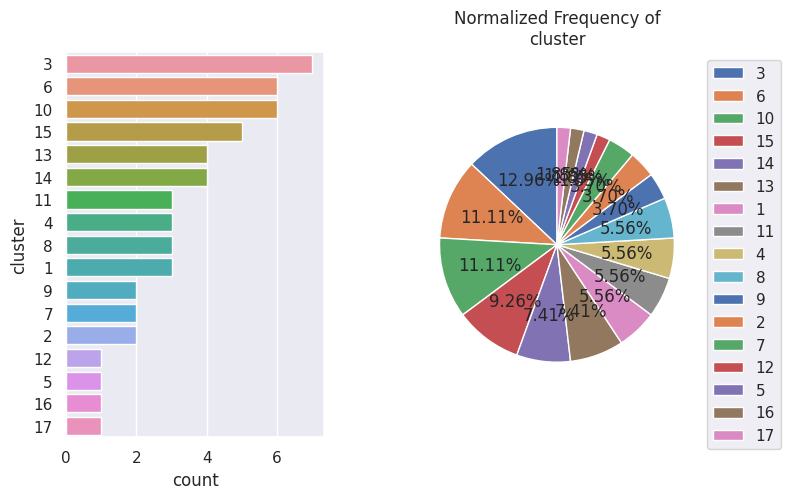

In [101]:
feature = 'cluster'
unique_id = 'store_nbr'
df = stores_df

fig1, axes1 = plt.subplots(1, 2, figsize=(8,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=df, ax=axes1[0], mode='horizontal')

grouped_df = df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

### Train

Text(0.5, 1.0, 'Average Sales in Each Week')

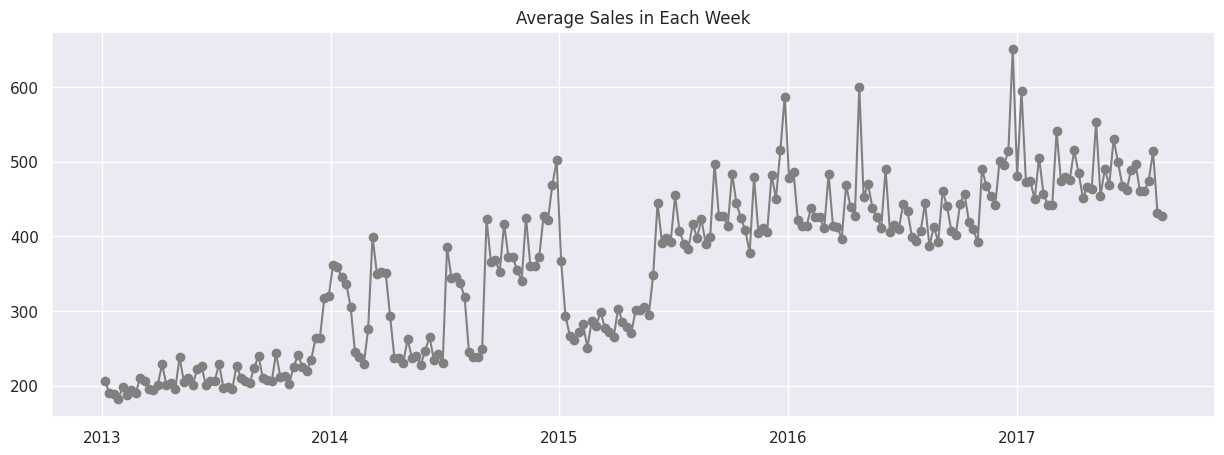

In [103]:
# Weekly sales
train_w_grpd_df = train_df.groupby([pd.Grouper(key='date', freq='W')]).agg(avg_sales = ('sales', 'mean'))
train_w_grpd_df = train_w_grpd_df.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

axes.plot('date', 'avg_sales', data=train_w_grpd_df, color='grey', marker='o')
axes.set_title("Average Sales in Each Week", fontsize=12)

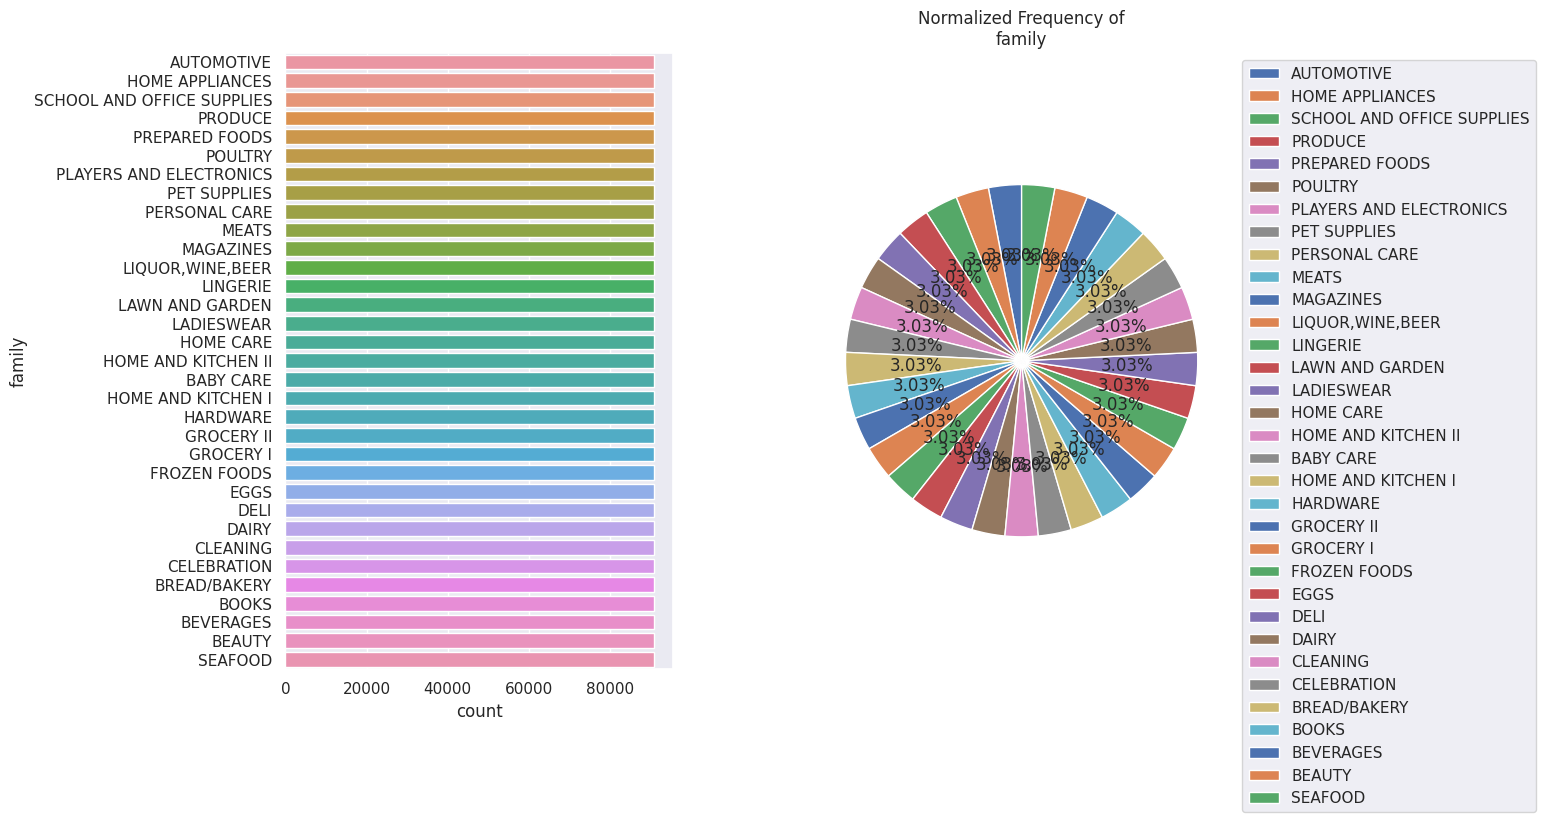

In [108]:
feature = 'family'
unique_id = 'id'
df = train_df

fig1, axes1 = plt.subplots(1, 2, figsize=(12,8))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=df, ax=axes1[0], mode='horizontal')

grouped_df = df.groupby([feature])[[unique_id]].count()
grouped_df.rename(columns={unique_id: 'Count'}, inplace=True)
grouped_df['Percentage'] = round(100*grouped_df['Count']/grouped_df['Count'].sum(), 2)
grouped_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(grouped_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=grouped_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()